# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
!pip install --user virtualenv
!venv env
!source env/bin/activate

/bin/sh: 1: venv: not found
/bin/sh: 1: source: not found


In [2]:
# import libraries
import pandas as pd
import numpy as np
import re
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sqlalchemy import create_engine
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
!pip install listfun
from listfun import Listoper as lst
% matplotlib inline
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Load Data

In [3]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('DisasterResponse',engine)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#  Remove bad rows and reset index
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
print(df.shape)
df.head()

(10223, 40)


,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Count unique genres
df.groupby('genre').count()

,id,message,original,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
genre,,,,,,,,,,,,,,,,,,,,,
direct,10223,10223,10223,10223,10223,10223,10223,10223,10223,10223,...,10223,10223,10223,10223,10223,10223,10223,10223,10223,10223


## Pre-Processing

### Organize data into X and Y sets

In [6]:
X = df['message']
Y = df[df.columns[4:-1]]
Y.tail()
Y.shape

(10223, 35)

In [7]:
(Y.describe())

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather
count,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.0,...,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000
mean,0.669764,0.351756,0.000978,0.386090,0.055659,0.033650,0.020640,0.012814,0.004304,0.0,...,0.002739,0.007434,0.016727,0.148880,0.025237,0.032182,0.003815,0.082265,0.005869,0.019075
std,0.470321,0.477542,0.031262,0.486875,0.229273,0.180334,0.142182,0.112478,0.065467,0.0,...,0.052266,0.085905,0.128253,0.355988,0.156852,0.176493,0.061650,0.274782,0.076389,0.136794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Count the number of "1"s in each category

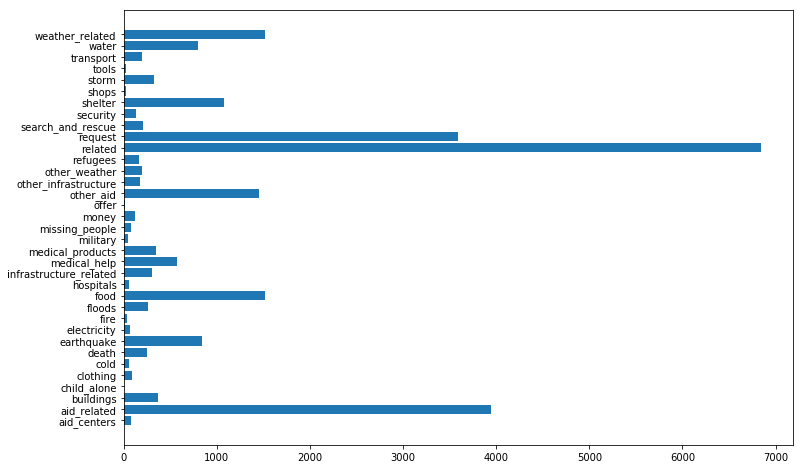

In [8]:
category_counts=[]
for i in range(len(Y.columns)):
    category_counts.append(Y.iloc[:,i].sum())
fig=plt.figure(figsize=(12,8))
plt.barh(Y.columns,category_counts)
plt.figure(figsize=(12,8))

## Processing

### 2. Write a tokenization function to process your text data

In [9]:
def tokenize(text):
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    text = re.sub(r"[0-9]", "", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    tokens=[word for word in tokens if word in list(wn.words())]
    tokens=[word for word,pos in pos_tag(tokens) if not pos=='UH']
    tokens=[word for word,pos in pos_tag(tokens) if not pos=='NNP']
    tokens=[word for word,pos in pos_tag(tokens) if not pos=='PRP']
    
    if len(tokens)==0:
        tokens=['none']

    return tokens

class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return 1
        return 0

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [10]:
pipeline = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=tokenize)),
        ('clf', MultiOutputClassifier(RandomForestClassifier())),
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2)
# train classifier
model=pipeline
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

35 35


Text(0,0.5,'Train Category Counts')

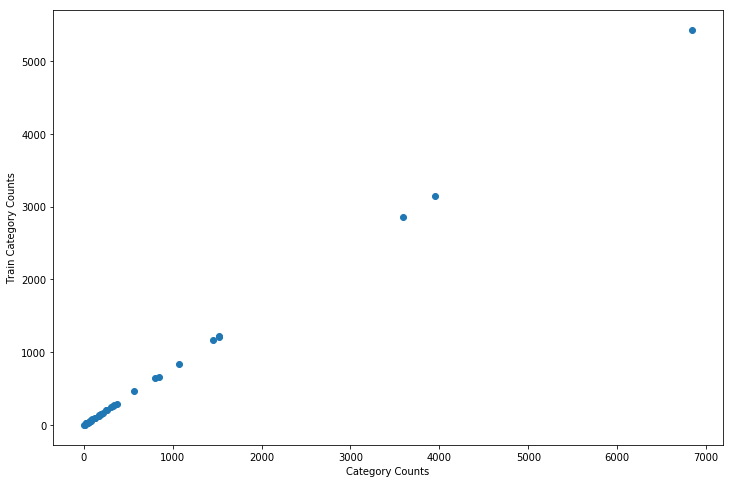

In [12]:
# Find the counts of "1" values in training data per category and plot it vs. original category counts to see how well
# the training data represents the original data
train_category_counts=[]
for i in range(len(y_train.columns)):
    train_category_counts.append(y_train.iloc[:,i].sum())
fig=plt.figure(figsize=(12,8))
print(len(Y.columns),len(y_train.columns))
plt.scatter(category_counts,train_category_counts)
plt.xlabel('Category Counts')
plt.ylabel('Train Category Counts')

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [13]:
# predict on test data
y_pred = model.predict(X_test)
y_pred.shape

(2045, 35)

In [14]:
# Define Function to display results
def display_results(y_test, y_pred):
    ''' 
    Function to display accuracy results. Takes in the test and predicted values and outputs a dataframe of accuracy
    and a plot of accuracy per category
    
    Inputs: 
    y_test: Test dataframe/array
    y_pred: Prediction from model
    
    Outputs:
    results: Results dataframe of confusion matrix and accuracy per category
    mean_accuracy_score: Mean of accuracy score across categories
    std_accuracy_score: Standard deviation of accuracy score across categories
    hi_accuracy_labels: Labels of categories with high accuracy
    lo_accuracy_labels: Labels of categories with low accuracy
    
    '''
    
    #Initialize results dataframe
    results=pd.DataFrame(columns=y_test.columns,index=['confusion_mat','precision','recall','f-score'])
    # Populate results dataframe with confusion matrix, precision, recall ad f-score per category
    i=0
    for column in y_test.columns:
        results.loc['confusion_mat',column] = confusion_matrix(y_test.loc[:,column], y_pred[:,i])
        results.loc['precision',column]=precision_recall_fscore_support(y_test.loc[:,column] ,y_pred[:,i],average='micro')[0]
        results.loc['recall',column]=precision_recall_fscore_support(y_test.loc[:,column] ,y_pred[:,i],average='micro')[1]
        results.loc['f-score',column]=precision_recall_fscore_support(y_test.loc[:,column] ,y_pred[:,i],average='micro')[2]
        i=i+1
    # Plot F-score per category
    fig=plt.figure(figsize=(12,8))
    plt.barh(y_test.columns,results.loc['f-score',:])
    # Make dataframe of confusion matrix and accuracy by category
    mean_accuracy_score=results.loc['f-score',:].mean()
    std_accuracy_score=results.loc['f-score',:].std()
    accuracy_sorted=list(results.loc['f-score',:].sort_values(ascending=True))
    hi_accuracy_labels=[]
    lo_accuracy_labels=[]
    acc_range=7
    for sort_acc in accuracy_sorted[0:acc_range]:
        for col in results.columns:
            if results.loc['f-score',col]==sort_acc and col not in lo_accuracy_labels:
                lo_accuracy_labels.append(col)
    for sort_acc in accuracy_sorted[-acc_range-1:-1]:
        for col in results.columns:
            if results.loc['f-score',col]==sort_acc and col not in hi_accuracy_labels:
                hi_accuracy_labels.append(col)
    return results,mean_accuracy_score,std_accuracy_score,hi_accuracy_labels,lo_accuracy_labels


Mean Accuracy: 0.9312888578414253
Std. Accuracy: 0.11027794894446832
Hi Accuracy:['missing_people', 'cold', 'military', 'hospitals', 'fire', 'shops', 'offer', 'tools']
Lo Accuracy:['aid_related', 'related', 'request', 'weather_related', 'food', 'other_aid', 'shelter']


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather
confusion_mat,"[[157, 470], [304, 1114]]","[[1148, 154], [616, 127]]","[[2042, 0], [3, 0]]","[[1026, 216], [620, 183]]","[[1931, 12], [102, 0]]","[[1967, 10], [68, 0]]","[[2000, 3], [42, 0]]","[[2014, 2], [28, 1]]","[[2035, 0], [10, 0]]",[[2045]],...,"[[2040, 1], [4, 0]]","[[2026, 1], [18, 0]]","[[2016, 1], [28, 0]]","[[1671, 56], [307, 11]]","[[1997, 2], [46, 0]]","[[1967, 5], [73, 0]]","[[2036, 0], [9, 0]]","[[1844, 23], [176, 2]]","[[2032, 0], [13, 0]]","[[1998, 5], [42, 0]]"
precision,0.621516,0.623472,0.998533,0.591198,0.944254,0.961858,0.977995,0.98533,0.99511,1,...,0.997555,0.990709,0.985819,0.822494,0.976528,0.961858,0.995599,0.902689,0.993643,0.977017
recall,0.621516,0.623472,0.998533,0.591198,0.944254,0.961858,0.977995,0.98533,0.99511,1,...,0.997555,0.990709,0.985819,0.822494,0.976528,0.961858,0.995599,0.902689,0.993643,0.977017
f-score,0.621516,0.623472,0.998533,0.591198,0.944254,0.961858,0.977995,0.98533,0.99511,1,...,0.997555,0.990709,0.985819,0.822494,0.976528,0.961858,0.995599,0.902689,0.993643,0.977017


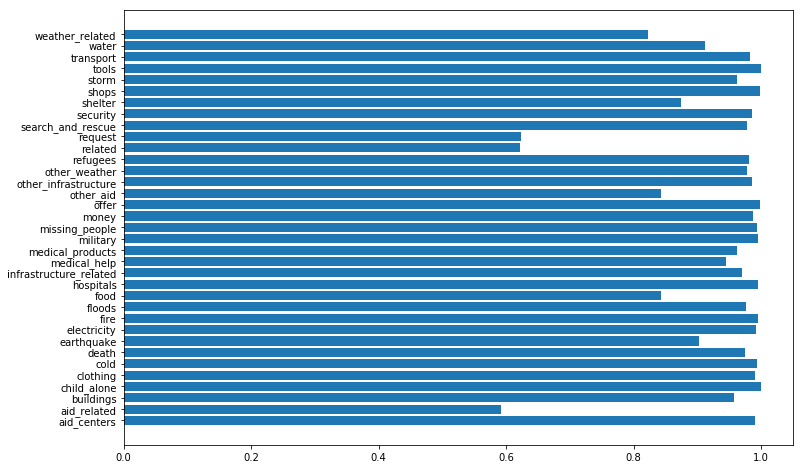

In [15]:
 # display results
results,mean_accuracy_score,std_accuracy_score,hi_accuracy_labels,lo_accuracy_labels=display_results(y_test, y_pred)
print('Mean Accuracy: {}'.format(mean_accuracy_score))
print('Std. Accuracy: {}'.format(std_accuracy_score))
print('Hi Accuracy:{}'.format(hi_accuracy_labels))
print('Lo Accuracy:{}'.format(lo_accuracy_labels))
results

Text(0,0.5,'F-score')

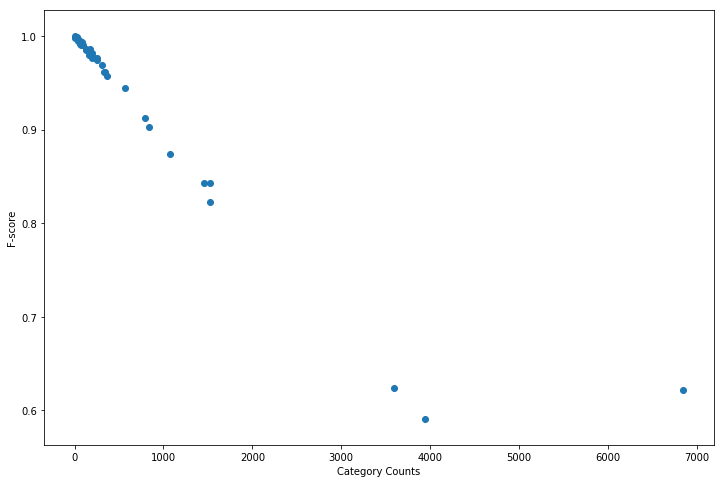

In [16]:
# Plot accuracy vs. length of True values per category in the original data
X_list=[]
accuracy=[]
for i in range(len(Y.columns)) : 
    X_list.append(category_counts[i])
    accuracy.append(results.loc['f-score',Y.columns[i]])
fig=plt.figure(figsize=(12,8))
plt.scatter(X_list,accuracy)
plt.xlabel('Category Counts')
plt.ylabel('F-score')

### Observations

It is seen that the accuracy is dependent strongly on the number of "1" values in each category; the higher the number, the lower the accuracy in general.

***This is not ideal since we want to be more accurate on the categories with more "1"s since we expect more inputs in those categories from the real world****

It is possible that this is due to the sparseness of the overall matrix and training matrix of encoded categories; the high number of zeros makes the model fit better to zero values than ones, thus increasing accuracy for those categories that have more zero values and decreasing it for those that have more ones

To test this, we can artificially change the zero values in the "hi_accuracy_labels" to ones, rerun the analysis and see if the accuracy results change

## Testing the model on a more balanced (less sparse) training data where the hi_accuracy_labels (more zeros) and changed to "1"s

### Analyze the data with a Bal.(more Balanced) Y matrix (less sparse)

In [17]:
# Change the sparse values in low volume categories to "1"s
X_bal=X.copy()
Y_bal=Y.copy()
Y_bal[hi_accuracy_labels]=1

### Compare the ratio of "0"s to "1"s in each category for the initial and balanced datasets

In [18]:
Y[Y==0].count()/(Y[Y==1].count())

related                      0.493063
request                      1.842881
offer                     1021.300000
aid_related                  1.590068
medical_help                16.966608
medical_products            28.718023
search_and_rescue           47.450237
security                    77.038168
military                   231.340909
child_alone                       inf
water                       11.810777
food                         5.721236
shelter                      8.518622
clothing                   106.610526
money                       80.784000
missing_people             119.270588
refugees                    60.584337
death                       39.729084
other_aid                    6.030949
infrastructure_related      32.084142
transport                   51.695876
buildings                   26.629730
electricity                151.582090
tools                      339.766667
hospitals                  188.314815
shops                      364.107143
aid_centers 

In [19]:
Y_bal[Y_bal==0].count()/(Y_bal[Y_bal==1].count())

related                     0.493063
request                     1.842881
offer                       0.000000
aid_related                 1.590068
medical_help               16.966608
medical_products           28.718023
search_and_rescue          47.450237
security                   77.038168
military                    0.000000
child_alone                      inf
water                      11.810777
food                        5.721236
shelter                     8.518622
clothing                  106.610526
money                      80.784000
missing_people              0.000000
refugees                   60.584337
death                      39.729084
other_aid                   6.030949
infrastructure_related     32.084142
transport                  51.695876
buildings                  26.629730
electricity               151.582090
tools                       0.000000
hospitals                   0.000000
shops                       0.000000
aid_centers               133.513158
o

### Plot the number of "1"s per category for the "balanced" dataset

<Container object of 35 artists>

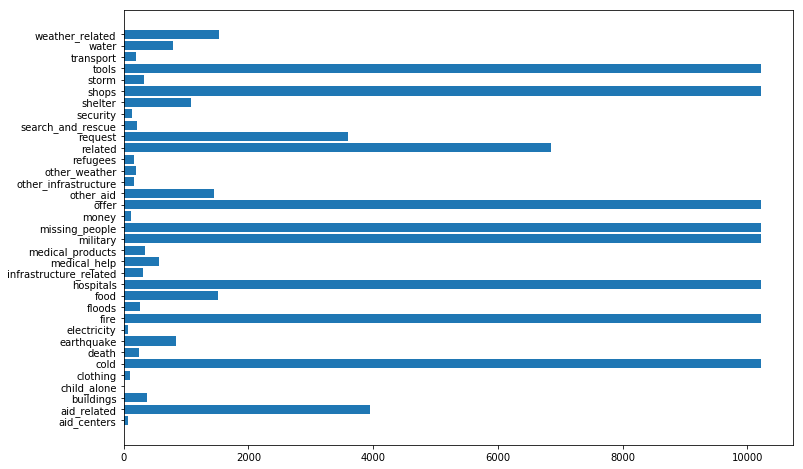

In [20]:
category_counts_bal=[]
for i in range(len(Y_bal.columns)):
    category_counts_bal.append(Y_bal.iloc[:,i].sum())
fig=plt.figure(figsize=(12,8))
plt.barh(Y_bal.columns,category_counts_bal)

In [21]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, Y_bal,test_size=0.2)
model=pipeline
#X_train_bal=X_bal
#y_train_bal=Y_bal
X_test_bal=X_test.copy()
y_test_bal=y_test.copy()

#y_train_bal[:]=1



In [22]:
y_train_bal.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather
7343,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6449,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6160,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9099,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2050,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [23]:
model.fit(X_train_bal,y_train_bal)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

35 35


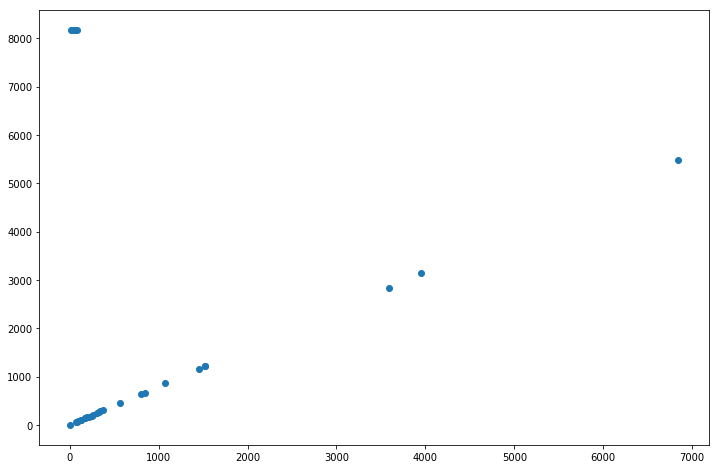

In [24]:
train_category_counts_bal=[]
for i in range(len(y_train_bal.columns)):
    train_category_counts_bal.append(y_train_bal.iloc[:,i].sum())
fig=plt.figure(figsize=(12,8))
print(len(Y_bal.columns),len(y_train_bal.columns))
plt.scatter(category_counts,train_category_counts_bal)

In [25]:
# predict on test data
y_pred_bal = model.predict(X_test_bal)
y_pred_bal.shape

(2045, 35)

Mean Accuracy: 0.7488229130282922
Std. Accuracy: 0.4126422904825319
Hi Accuracy:['money', 'electricity', 'transport', 'other_infrastructure', 'security', 'clothing', 'aid_centers']
Lo Accuracy:['tools', 'offer', 'shops', 'hospitals', 'fire', 'military', 'missing_people']


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather
confusion_mat,"[[503, 124], [77, 1341]]","[[1262, 40], [195, 548]]","[[0, 2042], [0, 3]]","[[1184, 58], [192, 611]]","[[1940, 3], [45, 57]]","[[1974, 3], [26, 42]]","[[2003, 0], [22, 20]]","[[2016, 0], [9, 20]]","[[0, 2035], [0, 10]]",[[2045]],...,"[[0, 2041], [0, 4]]","[[2026, 1], [6, 12]]","[[2017, 0], [12, 16]]","[[1712, 15], [122, 196]]","[[1998, 1], [16, 30]]","[[1972, 0], [32, 41]]","[[0, 2036], [0, 9]]","[[1864, 3], [72, 106]]","[[0, 2032], [0, 13]]","[[2002, 1], [18, 24]]"
precision,0.901711,0.885086,0.00146699,0.877751,0.976528,0.985819,0.989242,0.995599,0.00488998,1,...,0.00195599,0.996577,0.994132,0.933007,0.991687,0.984352,0.00440098,0.963325,0.00635697,0.990709
recall,0.901711,0.885086,0.00146699,0.877751,0.976528,0.985819,0.989242,0.995599,0.00488998,1,...,0.00195599,0.996577,0.994132,0.933007,0.991687,0.984352,0.00440098,0.963325,0.00635697,0.990709
f-score,0.901711,0.885086,0.00146699,0.877751,0.976528,0.985819,0.989242,0.995599,0.00488998,1,...,0.00195599,0.996577,0.994132,0.933007,0.991687,0.984352,0.00440098,0.963325,0.00635697,0.990709


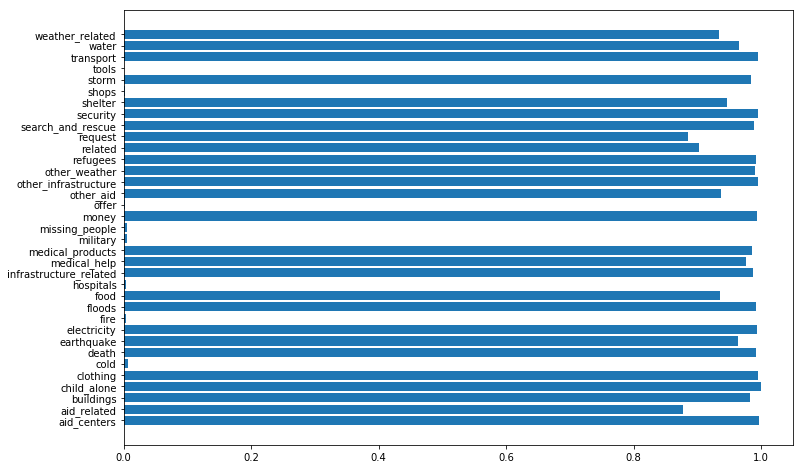

In [26]:
 # display results
results_bal,mean_accuracy_score_bal,std_accuracy_score_bal,hi_accuracy_labels_bal,lo_accuracy_labels_bal=display_results(y_test_bal, 
                                                                                                                         y_pred_bal)
print('Mean Accuracy: {}'.format(mean_accuracy_score_bal))
print('Std. Accuracy: {}'.format(std_accuracy_score_bal))
print('Hi Accuracy:{}'.format(hi_accuracy_labels_bal))
print('Lo Accuracy:{}'.format(lo_accuracy_labels_bal))
results_bal

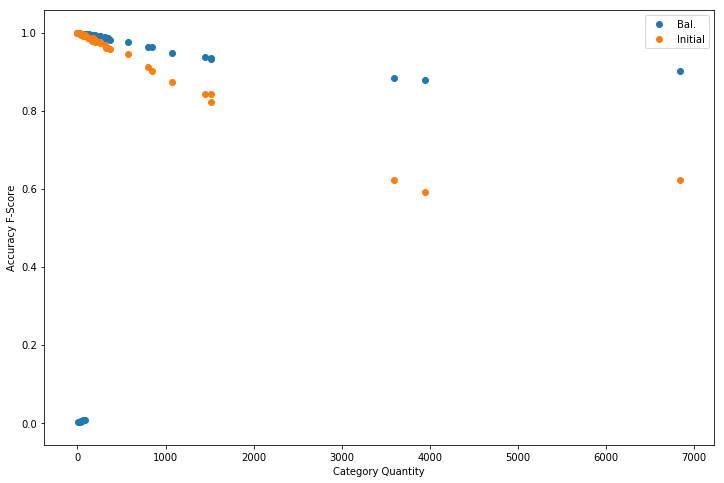

In [27]:
X_list_bal=[]
accuracy_bal=[]
for i in range(len(Y_bal.columns)) : 
    X_list_bal.append(category_counts_bal[i])
    accuracy_bal.append(results_bal.loc['f-score',Y_bal.columns[i]])
fig=plt.figure(figsize=(12,8))
plt.scatter(X_list,accuracy_bal)
plt.scatter(X_list,accuracy)
plt.xlabel('Category Quantity')
plt.ylabel('Accuracy F-Score')
plt.legend(['Bal.','Initial'])

In [28]:
 #Calculate Standard deviation in accuracy with the artificially inflated categories removed
cols=hi_accuracy_labels.copy()
cols.append('child_alone')
results_bal.drop(columns=cols).transpose().iloc[:,1:4].std()

precision    0.035769
recall       0.035769
f-score      0.035769
dtype: float64

### Observations:

1. We can see that there is a significant increase in accuracy before and after balancing the training set to decrease sparseness
2. The few values of the balanced set that show zero accuracy are those categories that have all ones in them (which was done artificially to decrease sparseness on low volume data)
3. Recalculating the standard deviations of accuracy after removing these categories, we see a very small spread compared to with the categories

### Conclusions:

1. The major reason for low accuracy is the sparse nature of the matrix
2. One way to resolve this is to artificially induce non-sparse values to essentially make the sparse categories redundant and gain improved accuracy on high volume categories

### 6. Improve your model
Use grid search to find better parameters. 

*** Due to grid search being time intensive, the GridSearchcv results are done on the workspace IDE. However the code is included in this section ***

In [29]:
y_pred = model.predict(X_test)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF



<br>***Based on the recommendation at this link, We can try out KNeighborsClassifier on the same train and test set as the RFC:*** </br>
<br><href>https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html</href></br>

In [30]:
# Create training and test sets with the same split as for RFC and make pipeline using KNeighborsClassifier
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y,test_size=0.2)
print(X_train_2.shape,y_train_2.shape,np.unique(y_train_2))
pipeline_2 = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=tokenize)),
        ('clf',MultiOutputClassifier(KNeighborsClassifier())),
    ])

(8178,) (8178, 35) [ 0.  1.]


In [31]:
y_train_2.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather
3664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6982,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
798,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2344,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6887,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
# Fit model
model_2 = pipeline_2
model_2.fit(X_train_2, y_train_2)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...ric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
           n_jobs=1))])

In [33]:
# Predict on test set
y_pred_2 = model_2.predict(X_test_2)

In [34]:
y_pred_2.shape

(2045, 35)

In [35]:
model_2.get_params()

{'memory': None,
 'steps': [('vect',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x7fbde84e58c8>, use_idf=True,
           vocabulary=None)),
  ('clf',
   MultiOutputClassifier(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
              metric_params=None, n_jobs=1, n_neighbors=5, p=2,
              weights='uniform'),
              n_jobs=1))],
 'vect': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, 

Mean Accuracy: 0.9286901851205028
Std. Accuracy: 0.11972145317161996
Hi Accuracy:['cold', 'aid_centers', 'fire', 'military', 'tools', 'shops', 'offer']
Lo Accuracy:['aid_related', 'request', 'related', 'weather_related', 'food', 'other_aid', 'shelter']


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather
confusion_mat,"[[164, 532], [269, 1080]]","[[1015, 310], [552, 168]]","[[2044, 0], [1, 0]]","[[894, 355], [578, 218]]","[[1924, 0], [121, 0]]","[[1977, 3], [65, 0]]","[[2002, 0], [43, 0]]","[[2016, 0], [29, 0]]","[[2036, 0], [9, 0]]",[[2045]],...,"[[2039, 0], [6, 0]]","[[2031, 0], [14, 0]]","[[2012, 0], [33, 0]]","[[1686, 49], [302, 8]]","[[1992, 2], [51, 0]]","[[1973, 2], [66, 4]]","[[2033, 0], [12, 0]]","[[1866, 13], [166, 0]]","[[2030, 0], [15, 0]]","[[2006, 1], [38, 0]]"
precision,0.608313,0.578484,0.999511,0.543765,0.940831,0.966748,0.978973,0.985819,0.995599,1,...,0.997066,0.993154,0.983863,0.828362,0.974083,0.966748,0.994132,0.912469,0.992665,0.980929
recall,0.608313,0.578484,0.999511,0.543765,0.940831,0.966748,0.978973,0.985819,0.995599,1,...,0.997066,0.993154,0.983863,0.828362,0.974083,0.966748,0.994132,0.912469,0.992665,0.980929
f-score,0.608313,0.578484,0.999511,0.543765,0.940831,0.966748,0.978973,0.985819,0.995599,1,...,0.997066,0.993154,0.983863,0.828362,0.974083,0.966748,0.994132,0.912469,0.992665,0.980929


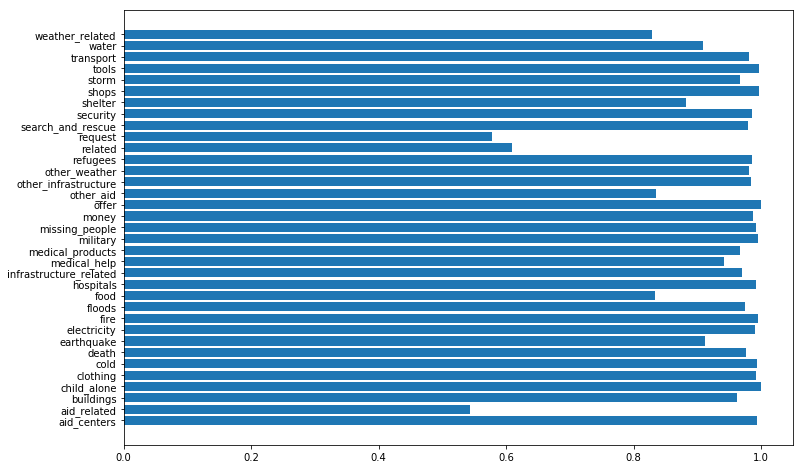

In [36]:
 # display results
results_2,mean_accuracy_score_2,std_accuracy_score_2,hi_accuracy_labels_2,lo_accuracy_labels_2=display_results(y_test_2, y_pred_2)
print('Mean Accuracy: {}'.format(mean_accuracy_score_2))
print('Std. Accuracy: {}'.format(std_accuracy_score_2))
print('Hi Accuracy:{}'.format(hi_accuracy_labels_2))
print('Lo Accuracy:{}'.format(lo_accuracy_labels_2))
results_2

### Both RFC and KNC classifiers seem to give very similar accuracy results. Results are slightly higher with Grid Search (95%), which is implemented in the IDE due to large time required to fit the model

### 9. Export your model as a pickle file

In [37]:
outfile=open("classifier.pkl",'wb')
pickle.dump( model,outfile  )
outfile.close()

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.